#                                                                   Building a Bigram from Scratch

###  Download all the imagenet classes

In [1]:
import requests

url = "https://storage.googleapis.com/bit_models/imagenet21k_wordnet_lemmas.txt"

def get_imagenet_classes(url):
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Failed to download file from {url}")

    class_lines = response.text.splitlines()
    classes = []

    for line in class_lines:
        line_classes = line.split(", ")
        classes.extend(line_classes)

    return classes

imagenet_classes = get_imagenet_classes(url)

with open("imagenet_classes.txt", "w") as f:
    for item in imagenet_classes:
        f.write(f"{item}\n")

print(f"Total classes: {len(imagenet_classes)}")
print("First 10 classes:", imagenet_classes[:10])

Total classes: 40742
First 10 classes: ['organism', 'being', 'benthos', 'heterotroph', 'cell', 'person', 'individual', 'someone', 'somebody', 'mortal']


### cleanup

In [2]:
import re

def clean_imagenet_classes(classes):
    cleaned_classes = []
    for word in classes:
        cleaned_word = re.sub(r"[:\-.,/\d'_]", '', word)
        if cleaned_word:
            cleaned_classes.append(cleaned_word)
    return cleaned_classes

cleaned_imagenet_classes = clean_imagenet_classes(imagenet_classes)
print(f"Total cleaned classes: {len(cleaned_imagenet_classes)}")
print("First 10 cleaned classes:", cleaned_imagenet_classes[:10])

Total cleaned classes: 40740
First 10 cleaned classes: ['organism', 'being', 'benthos', 'heterotroph', 'cell', 'person', 'individual', 'someone', 'somebody', 'mortal']


In [3]:
print(f" min length {min(len(w) for w in cleaned_imagenet_classes)}")
print(f" max length {max(len(w) for w in cleaned_imagenet_classes)}")

 min length 1
 max length 41


In [4]:
print(type(cleaned_imagenet_classes[0]))
print(type(cleaned_imagenet_classes[:1]))

<class 'str'>
<class 'list'>


### append special tokens

In [5]:
b = {}
for w in cleaned_imagenet_classes:
  chs = ['<Q>'] + list(w) + ['<Q>']
  for ch1,ch2 in zip(chs, chs[1:]):
    bigram = (ch1, ch2)
    b[bigram]= b.get(bigram, 0) + 1

In [6]:
sorted(b.items(), key = lambda kv: -kv[1])

[(('e', 'r'), 10384),
 (('e', '<Q>'), 6661),
 (('a', 'n'), 6467),
 (('i', 'n'), 6325),
 (('r', '<Q>'), 5694),
 (('a', 'r'), 5421),
 (('t', 'e'), 4759),
 (('l', 'e'), 4702),
 (('r', 'a'), 4423),
 (('r', 'i'), 4369),
 (('o', 'r'), 4317),
 (('<Q>', 's'), 4242),
 (('r', 'e'), 4241),
 (('o', 'n'), 4113),
 (('a', 't'), 4109),
 (('s', 't'), 4045),
 (('a', 'l'), 4042),
 (('u', 's'), 4036),
 (('l', 'a'), 4006),
 (('t', '<Q>'), 3788),
 (('<Q>', 'c'), 3769),
 (('i', 's'), 3604),
 (('r', 'o'), 3585),
 (('s', '<Q>'), 3532),
 (('e', 'n'), 3446),
 (('c', 'a'), 3434),
 (('l', 'i'), 3411),
 (('a', '<Q>'), 3398),
 (('e', 'a'), 3327),
 (('e', 'l'), 3214),
 (('i', 'c'), 3177),
 (('n', '<Q>'), 3088),
 (('n', 'e'), 3013),
 (('c', 'h'), 2951),
 (('c', 'o'), 2942),
 (('t', 'a'), 2911),
 (('n', 'g'), 2884),
 (('n', 't'), 2881),
 (('l', 'l'), 2859),
 (('<Q>', 'b'), 2828),
 (('m', 'a'), 2797),
 (('a', 'c'), 2776),
 (('l', 'o'), 2676),
 (('i', 'a'), 2668),
 (('<Q>', 'p'), 2659),
 (('s', 'e'), 2651),
 (('e', 't'),

### create a mapping

In [7]:
import torch
total_charachters = sorted(list(set(''.join(cleaned_imagenet_classes))))
N = torch.zeros((len(total_charachters)+1,len(total_charachters)+1), dtype=torch.int32)
string_to_int = {string:integer+1 for integer, string in enumerate(total_charachters)}
string_to_int['<Q>'] = 0
print(string_to_int)
int_to_string = {integer:string for string,integer in string_to_int.items()}

{'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26, 'a': 27, 'b': 28, 'c': 29, 'd': 30, 'e': 31, 'f': 32, 'g': 33, 'h': 34, 'i': 35, 'j': 36, 'k': 37, 'l': 38, 'm': 39, 'n': 40, 'o': 41, 'p': 42, 'q': 43, 'r': 44, 's': 45, 't': 46, 'u': 47, 'v': 48, 'w': 49, 'x': 50, 'y': 51, 'z': 52, '<Q>': 0}


### populate the tensor that stores the counts

In [8]:
for w in cleaned_imagenet_classes:
  chs = ['<Q>'] + list(w) + ['<Q>']
  for ch1,ch2 in zip(chs, chs[1:]):
    integer1 = string_to_int[ch1]
    integer2 = string_to_int[ch2]
    N[integer1, integer2] += 1

### visualize

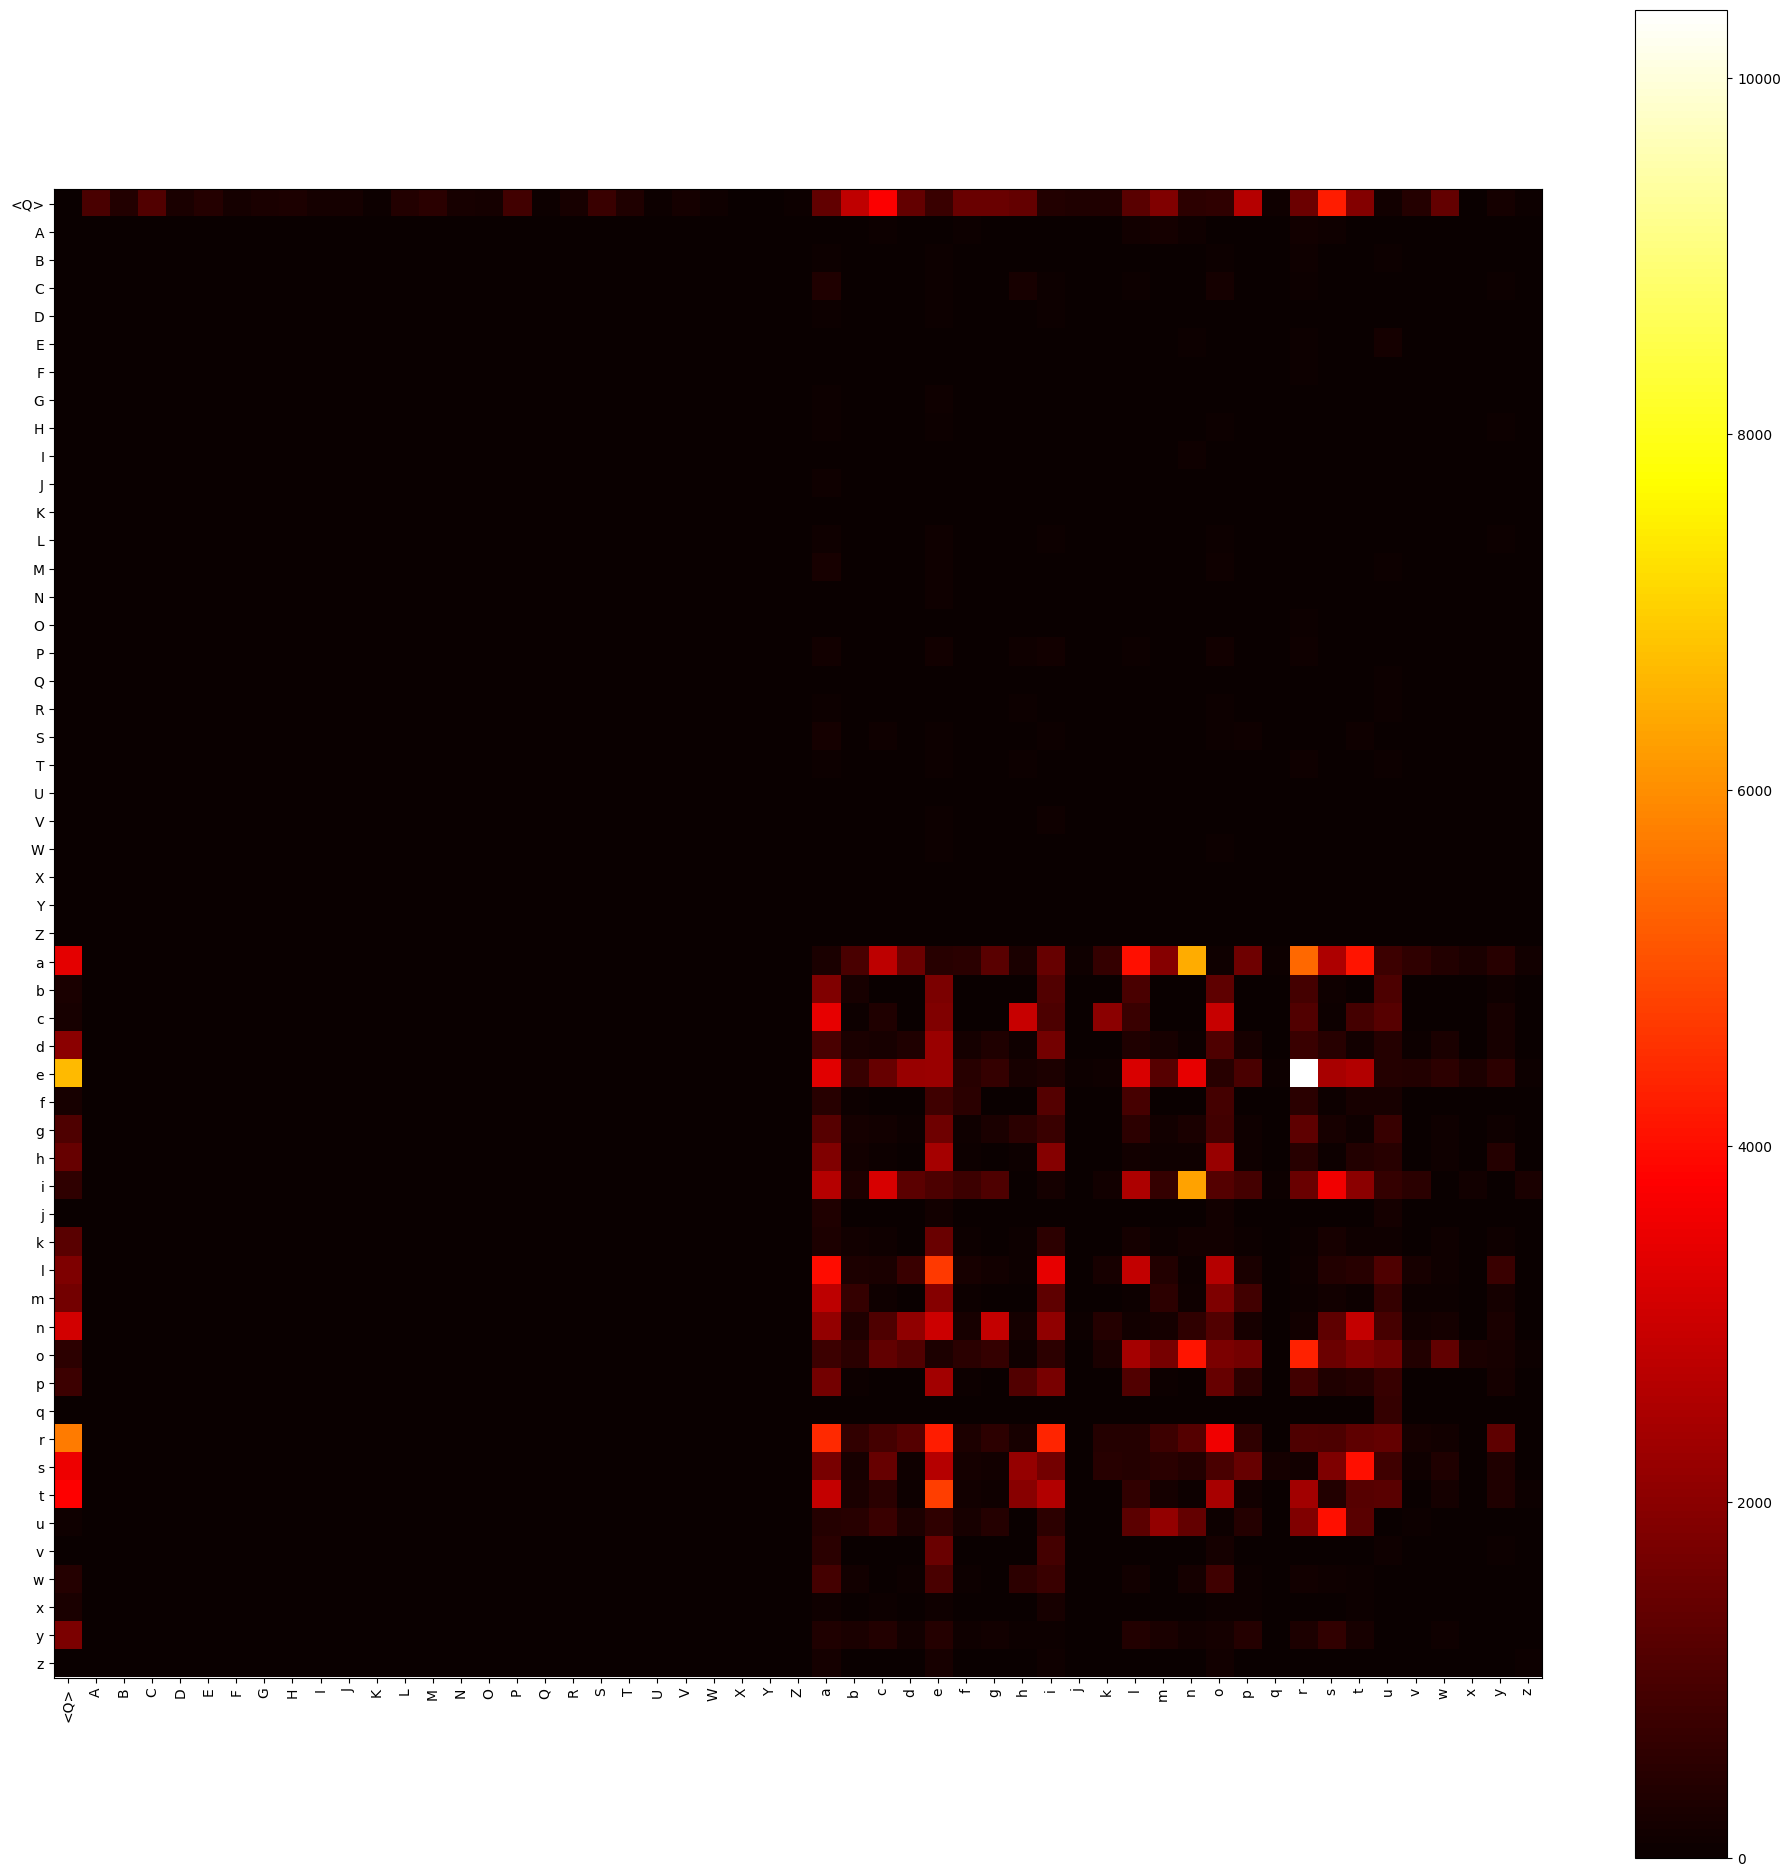

In [9]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

row_labels = [int_to_string[i] for i in range(N.shape[0])]
col_labels = [int_to_string[j] for j in range(N.shape[1])]

plt.figure(figsize=(24, 24))
plt.imshow(N, cmap='hot', interpolation='nearest')
plt.colorbar()

plt.xticks(ticks=np.arange(N.shape[1]), labels=col_labels, rotation=90)
plt.yticks(ticks=np.arange(N.shape[0]), labels=row_labels)

plt.show()

### convert to prob

In [10]:
p = N[3].float()
p = p / p.sum()
p

tensor([0.0069, 0.0009, 0.0009, 0.0000, 0.0086, 0.0017, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0009, 0.0000, 0.0000, 0.0034, 0.0000,
        0.0034, 0.0017, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.3110, 0.0017, 0.0009, 0.0009, 0.0679, 0.0000, 0.0000, 0.1770, 0.0601,
        0.0000, 0.0000, 0.0455, 0.0000, 0.0060, 0.1615, 0.0000, 0.0000, 0.0481,
        0.0000, 0.0017, 0.0335, 0.0000, 0.0000, 0.0000, 0.0558, 0.0000])

In [11]:
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples=2, replacement=True, generator=g)
for x in ix:
  print(f" char: {int_to_string[x.item()]} prob: {p[x].item()}")

 char: l prob: 0.045532647520303726
 char: o prob: 0.16151203215122223


In [12]:
# normalize with smoothing
P = (N+1).float()
P /= P.sum(1, keepdim=True)

In [13]:
P[0]

tensor([2.4514e-05, 2.3999e-02, 9.1928e-03, 2.7529e-02, 6.2511e-03, 1.0713e-02,
        4.5841e-03, 6.8149e-03, 7.3542e-03, 4.7312e-03, 4.0938e-03, 1.8631e-03,
        9.6830e-03, 1.2306e-02, 5.0009e-03, 4.7067e-03, 2.1033e-02, 1.5689e-03,
        5.9814e-03, 1.8116e-02, 8.9231e-03, 1.7650e-03, 4.4615e-03, 2.6475e-03,
        5.6382e-04, 6.8639e-04, 1.1522e-03, 3.3535e-02, 6.9350e-02, 9.2418e-02,
        3.4712e-02, 1.8582e-02, 3.5962e-02, 3.6109e-02, 3.4736e-02, 9.7811e-03,
        7.9916e-03, 8.9721e-03, 2.9956e-02, 4.5375e-02, 1.3066e-02, 1.4414e-02,
        6.5207e-02, 2.6230e-03, 3.6943e-02, 1.0401e-01, 4.6013e-02, 3.6281e-03,
        1.0345e-02, 3.4442e-02, 2.6965e-04, 4.6086e-03, 1.2012e-03])

### sample of multinomial dist

In [14]:
g = torch.Generator().manual_seed(2147483647)
for i in range(5):

  out = []
  ix = 0
  while True:
    p = P[ix]
    ix = torch.multinomial(p, num_samples=1, replacement=True).item()
    out.append(int_to_string[ix])
    if ix == 0:
      break
  print(''.join(out))

lidrinsarorermpumared<Q>
syagh<Q>
Tbolfedskeruspsttiwshinerarffolrh<Q>
percougicapumerceosdoum<Q>
bequramolixvedpyrafsou<Q>


#### GOAL:
- maximize likelihood of the data w.r.t. model parameters (statistical modeling)

    -> equivalent to maximizing the log likelihood (because log is monotonic)
  
    -> equivalent to minimizing the negative log likelihood
   
    -> equivalent to minimizing the average negative log likelihood

In [15]:
log_likelihood = 0.0
n = 0
for w in cleaned_imagenet_classes:
  chs = ['<Q>'] + list(w) + ['<Q>']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = string_to_int[ch1]
    ix2 = string_to_int[ch2]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1
    #print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f'{log_likelihood}')
nloglik = -log_likelihood
print(f'{nloglik}')
print(f'{nloglik/n}')

-1271929.25
1271929.25
2.6620705127716064


#### create training set of bigrams (x,y)

In [16]:
xs , ys = [] , []
for w in cleaned_imagenet_classes:
  chs = ['<Q>'] + list(w) + ['<Q>']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = string_to_int[ch1]
    ix2 = string_to_int[ch2]
    # print(ch1, ch2)
    xs.append(ix1)
    ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

The training set is something like this, lets say you have a word called " happy " . Break it down as follows

    [S] h a p p y [E]

    X = [S] h p p y

    Y =  h  a p y [E]

In [33]:
xs[:]

tensor([ 0, 41, 44,  ..., 41, 38, 31])

In [29]:
ys

tensor([41, 44, 33,  ..., 38, 31,  0])

#### one hot encoding

In [19]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=len(string_to_int)).float()

In [20]:
xenc.shape

torch.Size([477797, 53])

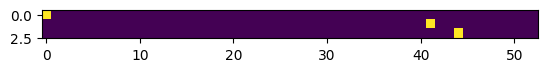

In [30]:
plt.imshow(xenc[:3,:])

In [34]:
xenc.dtype

torch.float32

In [41]:
W = torch.randn((len(string_to_int), len(string_to_int))) # (output, input) single hidden layer
t= xenc @ W  # 477797,53 @ 53,53 -> 477797,53 (since each word is encoded in the 53 dimensional encoding)
t.shape

torch.Size([477797, 53])

In [42]:
logits = xenc @ W
count = logits.exp() # similar to counting the occurences of each char as we did in the N
probs = count / count.sum(1, keepdims=True)
probs

tensor([[0.0041, 0.0045, 0.0033,  ..., 0.0049, 0.0142, 0.0241],
        [0.0591, 0.0311, 0.0235,  ..., 0.0149, 0.0111, 0.0538],
        [0.0363, 0.0106, 0.0317,  ..., 0.0115, 0.0154, 0.0716],
        ...,
        [0.0591, 0.0311, 0.0235,  ..., 0.0149, 0.0111, 0.0538],
        [0.0017, 0.0094, 0.0081,  ..., 0.0477, 0.0130, 0.0172],
        [0.0080, 0.0307, 0.0176,  ..., 0.0048, 0.0140, 0.1188]])

In [43]:
probs.shape

torch.Size([477797, 53])

In [50]:
nlls = torch.zeros(len(xs))
for i in range(len(xs)):
  x = xs[i].item() # input char index
  y = ys[i].item() # output char index
  #print("--------")
  #print(f'bigram example {i+1}: {int_to_string[x]} , {int_to_string[y]} (indexes {x},{y})')
  #print(f'input to neural net: {int_to_string[x]}')
  #print(f'output probability from the neural net: {probs[i]}')
  #print('label (actual next character)', y)
  p = probs[i, y]
  #print('probability assigned by the net to the the correct character', p.item())
  logp = torch.log(p)
  #print('log likelihood', logp.item())
  nll = -logp
  # print('negative log likelihood', nll.item())
  nlls[i] = nll

print('=========')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())

average negative log likelihood, i.e. loss = 4.446805477142334


#### lets optimize

In [53]:
xs

tensor([ 0, 41, 44,  ..., 41, 38, 31])

In [54]:
ys

tensor([41, 44, 33,  ..., 38, 31,  0])

In [61]:
# initialize some weights randomly
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((len(string_to_int), len(string_to_int)), generator=g, requires_grad=True)


In [62]:
# forward pass
xenc = F.one_hot(xs, num_classes=len(string_to_int)).float() # input to the network: one-hot encoding (477797,53)
logits = xenc @ W # predict log-counts (477797,53) @ (53,53) -> (477797,53)
# compute softmax
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
loss = -probs[torch.arange(len(xs)), ys].log().mean()

In [63]:
print(loss.item())

4.539838790893555


In [64]:
# backward pass
W.grad = None # set to zero the gradient
loss.backward()

In [65]:
W.data += -0.1 * W.grad

# gradient descent

In [66]:
# initialize some weights randomly
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((len(string_to_int), len(string_to_int)), generator=g, requires_grad=True)

In [72]:
for k in range(20):

  # forward pass
  xenc = F.one_hot(xs, num_classes=len(string_to_int)).float() # input to the network: one-hot encoding
  logits = xenc @ W # predict log-counts
  counts = logits.exp() # counts, equivalent to N
  probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
  loss = -probs[torch.arange(len(xs)), ys].log().mean() + 0.01*(W**2).mean() # add some regularization term to penalize large weights
  print(loss.item())

  # backward pass
  W.grad = None # set to zero the gradient
  loss.backward()

  # update
  W.data += -50 * W.grad

2.788444757461548
2.787126302719116
2.785841941833496
2.784590005874634
2.783369779586792
2.7821803092956543
2.781019926071167
2.7798879146575928
2.778782844543457
2.7777040004730225
2.776650905609131
2.7756221294403076
2.7746169567108154
2.773634195327759
2.772674083709717
2.771735668182373
2.770817756652832
2.7699193954467773
2.769041061401367
2.768181085586548


#### lets do some sampling

In [76]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):

  out = []
  ix = 0
  while True:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=len(string_to_int),).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character

    ix = torch.multinomial(p, num_samples=1, replacement=True).item()
    out.append(int_to_string[ix])
    if ix == 0:
      break
  print(''.join(out))

hnefingJDsteryyperochofHi<Q>
fvenetlanckNk<Q>
PERr<Q>
Gboverde<Q>
gryk<Q>
